In [1]:
import os
import obspy
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
%matplotlib inline
os.getcwd()

'/Users/albertkong/grillochallenge'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
signalmodel = load_model('signalmodel')
locmodel = load_model('locmodel')

2022-03-10 16:51:32.857967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-10 16:51:32.858228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [4]:
def detector_predict_test(trace):
    
    ## Things to Specify -- Ensure that they align with trained model
    # For rolling averages
    roll_short = 25
    roll_long = 50

    # For location segments
    window_step = 30
    window_size = 30
    
    # Probability cut-offs
    p_prob = 0.05 # for p-wave
    s_prob = 0.05 # for signal
    
    ## Reading in Trace and Splitting Channels
    sig_trace = trace.normalize()
    
    samp_rate = sig_trace.stats.sampling_rate
    start_time = sig_trace.stats.starttime
    
    sigs = sig_trace.data
    
    sig_df = pd.DataFrame(sigs, columns = ["trace"])
    
    sigfeatures = []
    
    ## Calculating various features needed for the signal model
    tr = sig_df["trace"]
    mag = abs(tr)
    d = {"trace":tr, "magnitude":mag}
    temp_df = pd.DataFrame(data = d)
    
    temp_df["STA"] = temp_df["magnitude"].rolling(roll_short).mean()
    temp_df["LTA"] = temp_df["magnitude"].rolling(roll_long).mean()
    temp_df["RAV"] = temp_df["STA"]/temp_df["LTA"]
    temp_df["STV"] = temp_df["magnitude"].rolling(roll_short).var()
    temp_df["LTV"] = temp_df["magnitude"].rolling(roll_long).var()

    temp_df.dropna(inplace = True)
    sigfeatures.append(temp_df.values)
    
    ## Predicting whether or not there is a pwave in the trace
    is_sig = signalmodel.predict(np.array(sigfeatures))
    print("Signal Prob:", is_sig[0][0])

    locfeatures = []

    ## If there is a pwave in the trace, continue to find location of pwave
    start_ind = 0
    end_ind = start_ind + window_size

    while end_ind < (1000 - roll_long):
        trwindow = temp_df["trace"].iloc[start_ind:end_ind]
        magwindow = temp_df["magnitude"].iloc[start_ind:end_ind]
        ravwindow = temp_df["RAV"].iloc[start_ind:end_ind]
        stvwindow = temp_df["STV"].iloc[start_ind:end_ind]
        ltvwindow = temp_df["LTV"].iloc[start_ind:end_ind]

        window_data = {"trace": trwindow, "magnitude": magwindow,
                            "RAV": ravwindow, "STV": stvwindow, "LTV": ltvwindow}

        window_df = pd.DataFrame(data = window_data)

        locfeatures.append(window_df.values)

        start_ind += window_step
        end_ind = start_ind + window_size

    prob_vec = locmodel.predict(np.array(locfeatures))
    
    # Since we know if there is a p-wave, it will be in the last 3 seconds:
    end_ind = len(prob_vec)
    beg_ind = len(prob_vec) - int(3*window_size/samp_rate + 1)
    p_segment = beg_ind + np.where(prob_vec[beg_ind:end_ind] == max(prob_vec[beg_ind:end_ind]))[0][0]
    print("P-wave Prob:", max(prob_vec[beg_ind:end_ind])[0])
        
    tick_delta = (p_segment + 0.5)*window_size + (roll_long - 1)
    print("Tick Index:", tick_delta)
        
    time_delta = (tick_delta)/samp_rate
    p_time = start_time + time_delta
        
    if (is_sig >= s_prob)|(max(prob_vec[beg_ind:end_ind]) > p_prob):
        return p_time
    else:
        return None

In [5]:
os.chdir('lse_challenge/data/signal')
signal_files = os.listdir()

In [50]:
signal_file = random.sample(signal_files, 1)
stream = obspy.read(signal_file[0])
tr = stream[0]
snr = sum(abs(tr.data[1000:1032]))/sum(abs(tr.data[1000-32:1000]))
print(snr)
cut = int((random.random()*3+0.5)*32.5)
tr.data = tr.data[cut:1000+cut]
correct_answer = tr.stats.starttime + (1000-cut)/tr.stats.sampling_rate
print(correct_answer)
p_arrival = 1000 - cut
print(p_arrival)

3.17681283866
2020-10-04T23:06:50.487000Z
910


Signal Prob: 0.975641
P-wave Prob: 0.135984
Tick Index: 934.0
Prediction Offset: 0.768


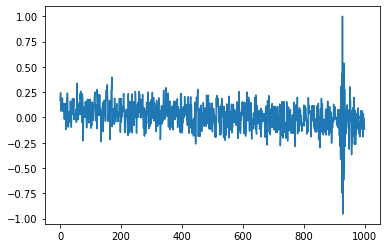

In [51]:
prediction = detector_predict_test(tr)
if(prediction):
    print("Prediction Offset:", abs(correct_answer-prediction))
else:
    print("Prediction:", prediction)
    
plt.plot(tr)